In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import useful_functions as uf
import density as den
import constants as cc
from scipy.interpolate import interp1d
import sys
sys.path.insert(0,'/home/zahra/hirax_tools/hirax_tools')
from array_config import HIRAXArrayConfig
from scipy.integrate import trapz
import pylab
from matplotlib.colors import LogNorm

In [2]:
cosmo=uf.cosmo

Mps_interpf=uf.Mps_interpf

n_points=40
n=n_points
z_r=6

x_e=1.

G=cc.G_const_Mpc_Msun_s/cc.M_sun_g

#rho_c=3*H0**2/(8.*np.pi*G)

rho_c=den.cosmo_densities(**cosmo)[0]*cc.M_sun_g #in units of g/Mpc^3

sigma_T=cc.sigma_T_Mpc

tau_r=0.055

T_rad=2.725 #In Kelvin

chi_r = uf.chi(z_r)

chi_m = uf.chi(1100)

chi_min=0.0001

k_min=1e-4

k_max=10

chi_array=np.linspace(chi_min,chi_m,n_points)

#tau_r=0.046*omega_b_0*h*x_e[np.sqrt(omega_M_0(1+z_r)**3+(1-omega_M_0))-1]

#get matter power spec data

mu_e=1.14

m_p=cc.m_p_g #in grams

rho_g0=cosmo['omega_b_0']*rho_c

#plt.loglog(uf.kabs,Mps_interpf(uf.kabs))

#plt.show()


zed=uf.zed

H=uf.H
chi=uf.chi
#chi_Z=chi(Z)
tau_inst=uf.tau_inst
f=uf.f
D=uf.D_1
r=uf.r
z=1.26
delta_z=0.0015

In [3]:
ell=np.geomspace(2.,1.e4,n_points)
kperp_arr=ell/chi(z)
kpar_arr=np.geomspace(1.e-4,.15,n_points)
y=kpar_arr*r(z)

In [4]:

#kpar_min=uf.kpar_min(z,delta_z)

def ionized_elec(Yp,N_He):

    x=(1-Yp*(1-N_He/4))/(1-Yp/2)

    return x



def density(z,rho_g0):

    rho_g=rho_g0*(1+z)**3

    return rho_g



def ionized_electron_number(z):

    n=ionized_elec(0.24,1)*density(z,rho_g0)/(mu_e*m_p)

    return n



def tau(z):

    tau_der=sigma_T*cc.c_light_Mpc_s*ionized_electron_number(z)/((1+z)*uf.H(z))

    tau=sp.integrate.trapz(tau_der,z)

    return tau

x=ionized_elec(0.24,0)


(-0.00031595205424304375, 'trapz of full')
(0.001846109547939049, 'trapz without cos')
-0.0021620616021820927


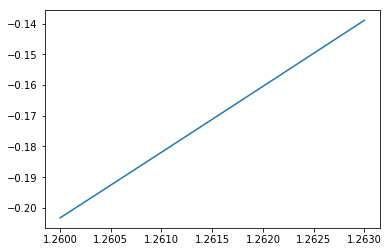

In [5]:
kpar_array=np.geomspace(1.e-2,.15,100)
Z_min=z
Z_max=z+2*delta_z

z2=np.geomspace(Z_min,Z_max,100)
f_z2=uf.f(z2)
D_z2=uf.D_1(z2)
H_z2=uf.H(z2)
r_z2=uf.r(z2)
tau_z2=uf.tau_inst(z2)
z_func=f_z2*D_z2**2*(1+z2)*np.exp(-tau_z2)
arg=kpar_array[0]*cc.c_light_Mpc_s*z/H_z2
cos_func=np.cos(arg)
z_func=f_z2*D_z2**2*(1+z2)*np.exp(-tau_z2)*cos_func
z_func_cos_1=f_z2*D_z2**2*(1+z2)*np.exp(-tau_z2)
print (trapz(z_func,z2),'trapz of full')
print (trapz(z_func_cos_1,z2),'trapz without cos')
print (trapz(z_func,z2)-trapz(z_func_cos_1,z2))
plt.plot(z2,cos_func)
#plt.plot(z2,z_func)
plt.show()
#plt.plot(z2,z_func)
#plt.show()

In [6]:
#original cross corr
def crosscorr(ell,z_i,y, delta_z,kp_perp,kp_par): #with the assumption that zi=z so no cos factor, and we have dz=redshift bin width=2*delta_z defined above
    n=n_points #number of points over which to integrate
    #y=np.geomspace(1.,3000.,n)
    Z_min=z_i#-delta_z
    Z_max=z_i+2*delta_z
    z=np.geomspace(Z_min,Z_max,n)
    T_mean_zi=uf.T_mean(z_i)
    chi_zi=chi(z_i)
    chi_z=chi(z)
    f_zi=uf.f(z_i)
    f_z=uf.f(z)
    D_zi=uf.D_1(z_i)
    r_zi=uf.r(z_i)
    D_z=uf.D_1(z)
    H_zi=uf.H(z_i)
    H_z=uf.H(z)
    tau_z=uf.tau_inst(z)
    kpar=y/uf.r(z_i)
    const=1.e6/(4.*np.pi**2)*T_rad*T_mean_zi**2/cc.c_light_Mpc_s*f_zi*D_zi**2*H_zi/(chi_zi**2*r_zi)/(1.+z_i)*x*(sigma_T*rho_g0/(mu_e*m_p))
    #Cl=np.array([])
    k_perp=ell/chi_zi
    k=np.sqrt(k_perp**2+kpar**2)
    rsd=1.+f_zi*kpar**2/k**2
    kp=np.sqrt(kp_perp**2+kp_par**2)
    cos_theta=kp_par/kp #cos_theta=u, theta is azimuthal angle between k' and z (line of sight) axis
    sin_theta=kp_perp/kp
    sin_gamma=kpar/k #gamma is measured between k and xy plane, i.e. elevation of k
    cos_gamma=k_perp/k
    zeta=sin_gamma*cos_theta+cos_gamma*sin_theta
    k_dot_kp=k_perp*kp_perp+kpar*kp_par#*zeta
    k_perp_dot_kp_perp=k_perp*kp_perp
    K=np.sqrt(k**2+kp**2-2*k_dot_kp)
    K_perp=np.sqrt(np.abs(k_perp**2+kp_perp**2-2*k_perp_dot_kp_perp))
    #theta_K=kpar/K/k**2*(k**2-k_dot_kp)-kp*k_perp*np.sqrt(np.abs(1-zeta**2))/k/K
    theta_K=(np.abs(kpar-kp_par))/K
    theta_kp=cos_theta
    #theta_kp=kpar*zeta/k+k_perp*np.sqrt(np.abs(1-zeta**2))/k
    #print (theta_K.min(),theta_K.max())
    #theta_K=np.where(theta_K > 0, theta_K, 0)
    I=theta_kp*(theta_kp/kp**2+theta_K/K/kp)
    #z_integral=sp.integrate.trapz(f_z*D_z**2*(1+z)*np.exp(-tau_z)*np.cos(kpar*cc.c_light_Mpc_s*z/H_z),z)
    arg=kpar*cc.c_light_Mpc_s*z/H_z
    cos_func=np.cos(arg)
    z_integral=sp.integrate.trapz(f_z*D_z**2*(1+z)*np.exp(-tau_z)*cos_func,z)
    integrand_1=z_integral*Mps_interpf(kp)*Mps_interpf(K)*rsd**2*theta_kp**2*kp_perp/kp**2
  #+theta_K/K/kp)#-mu*kp*np.gradient(Mps_interpf(k),axis=0))
    integrand_2=z_integral*Mps_interpf(kp)*Mps_interpf(K)*rsd**2*theta_kp*theta_K*kp_perp/kp/K

    #Cl=np.append(Cl,integral)
    return const*(integrand_1+integrand_2)


In [7]:
def Func_2d_redshift(ell,z,y,Func,delta_z):
    Z_min=z-delta_z
    Z_max=z+delta_z
    z_arr=np.geomspace(Z_min,Z_max,n)
    Func_mat=np.zeros((len(ell),len(y),len(z_arr)))
    for i in range(len(ell)):
        for j in range(len(y)):
            for z_ind in range(len(z_arr)):
                Func_ind=Func(ell[i],z_arr[z_ind],y[j],delta_z)
                Func_mat[i][j][z_ind]=Func_ind
    return Func_mat

def Func_noise_redshift(ell,z,y,Func,delta_z,Noise):
    Z_min=z-delta_z
    Z_max=z+delta_z
    z_arr=np.geomspace(Z_min,Z_max,n)
    Func_mat=np.zeros((len(ell),len(y),len(z_arr)))
    for i in range(len(ell)):
        for j in range(len(y)):
            for z_ind in range(len(z_arr)):
                Func_ind=Func(ell[i],z_arr[z_ind],y[j],delta_z,Noise)
                Func_mat[i][j][z_ind]=Func_ind
    return Func_mat

def Func_2d(ell,z,y,Func,delta_z):
    Func_mat=np.zeros((len(ell),len(y)))
    for i in range(len(ell)):
        for j in range(len(y)):
            Func_ind=Func(ell[i],z,y[j],delta_z)
            Func_mat[i][j]=Func_ind
    return Func_mat


def Func_noise(ell,z,y,Func,delta_z,Noise):
    Func_mat=np.zeros((len(ell),len(y)))
    for i in range(len(ell)):
        for j in range(len(y)):
            Func_ind=Func(ell[i],z,y[j],delta_z,Noise)
            Func_mat[i][j]=Func_ind
    return Func_mat


def Signal_integrated(ell,z,y,delta_z):
    Kp_perp=np.geomspace(1.e-6,1.,n)
    Kp_par=np.geomspace(1.e-6,.15,n)
    kp_perp,kp_par=np.meshgrid(Kp_perp,Kp_par)
    B=crosscorr(ell,z,y, delta_z,kp_perp,kp_par)
    integral=trapz(trapz(np.abs(B),Kp_perp,axis=0),Kp_par,axis=0)
    integral_sqrt=np.sqrt(np.abs(integral))
    return integral


In [8]:
Z_no_z=Func_2d(ell,z,y,Signal_integrated,delta_z)

In [9]:
Z_no_z=Z_no_z.T

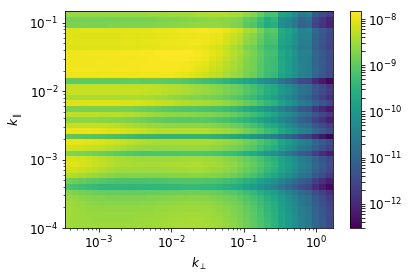

In [10]:
pylab.pcolormesh(kperp_arr,kpar_arr,Z_no_z,norm=LogNorm()) ;  cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
pylab.xlim([np.min(kperp_arr),np.max(kperp_arr)]) ; pylab.ylim([np.min(kpar_arr),np.max(kpar_arr)])
plt.xlabel(r'$k_\perp$',fontsize=12); plt.ylabel(r'$k_\parallel$',fontsize=12);
plt.xscale('log')
plt.yscale('log')
#plt.savefig('2D_bispec_fourier_z_1pt26_deltaz_pt005_and_below.png', dpi=300, bbox_inches='tight')
pylab.show()

In [11]:
def HiraxNoise(l,Ddish,Dsep,zi,delta_z): #the Dsep refers to the dish seperation including the dish diameter of 6. So we're assuming dishes are 1m away
        z_min=zi-delta_z
        z_max=zi+delta_z
        nu_21=1420
        nu_min=nu_21/(1+z_max) #743. #585. # #freq in MHz, these min and max values are based on HIRAX
        nu_max=nu_21/(1+z_min)#784. #665. #
        cp= HIRAXArrayConfig.from_n_elem_compact(1024,Dsep)
        nubar=(nu_min+nu_max)/2.

        Fov_deg=(cp.fov(frequency=nubar)) * ((180./np.pi)**2)
        Fov_str=(cp.fov(frequency=nubar))
        Tsys= 50. + 60.*((nubar/300.)**-2.5)
        lam=3.e8/(nubar*1.e6)
        Nbeam=1.
        npol=2.
        nu21=1420.e6
        Aeff=np.pi*((Ddish/2.)**2)*0.67
        Ttot=100.8e6 #36e6   4*365*24*3600.
        #Ttot=2*365*24*3600
        Sarea=15000.
        pconv=(chi(zi)**2)*r(zi)
        n_u=cp.baseline_density_spline(frequency=nubar)
        n=np.array([])
        for i in l:
            if n_u(i/(2.*np.pi))==0:
                n_u1=1/1e10
            else:
                n_u1=n_u(i/(2.*np.pi))
            n=np.append(n,n_u1)
        Nbs= 1024.*(1024.-1.)
        #norm=Nbs/sp.integrate.trapz(n*2*np.pi*(l/(2.*np.pi)), l/(2.*np.pi))
        C=n#*noprint (nu_min)
        A_bull= ((Tsys**2)*(lam**4)*Sarea) / (nu21*npol*Ttot*(Aeff**2)*Fov_deg*Nbeam)
        Warren=Tsys**2*lam**2/Aeff*4.*np.pi/(nu21*npol*Nbeam*Ttot)
        #return (Warren/C)*1e12
        return (A_bull/C)*1e12

ell_large=np.geomspace(1.e-6,1.e6,10000)



Hirax_noise_z_1pt26_deltaz_pt0015 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.26,0.0015), bounds_error=False)
Hirax_noise_z_1pt26_deltaz_pt015 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.26,0.015), bounds_error=False)
Hirax_noise_z_1pt26_deltaz_pt15 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.26,0.15), bounds_error=False)
Hirax_noise_z_1pt26_deltaz_1 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.26,1.), bounds_error=False)
Hirax_noise_z_2pt26_deltaz_pt0015 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,2.26,.0015), bounds_error=False)
Hirax_noise_z_pt9_deltaz_pt0015 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,.9,.0015), bounds_error=False)
Hirax_noise_z_1pt26_deltaz_pt005 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.26,0.005), bounds_error=False)

Hirax_noise_z_1_deltaz_pt2 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.,0.2), bounds_error=False)

Hirax_noise_z_pt81_deltaz_pt2 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,.81,0.2), bounds_error=False)
Hirax_noise_z_pt95_deltaz_pt2 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,.95,0.2), bounds_error=False)


#Noise=Hirax_noise_z_1pt26_deltaz_pt0015
Noise=Hirax_noise_z_1pt26_deltaz_pt0015

In [12]:
OV_1pt26_lower=np.load('C_l_ksz_z_1pt26_deltaz_pt0015_lower_100pts_2d.npy')

OV_1pt26_upper=np.load('C_l_ksz_z_1pt26_deltaz_pt0015_upper_100pts_2d.npy')

ell_loaded=OV_1pt26_lower[0,:]
OV_1pt26_lower_loaded=OV_1pt26_lower[1,:]
OV_1pt26_upper_loaded=OV_1pt26_upper[1,:]


OV_1pt26_lower_interp=interp1d(ell_loaded,OV_1pt26_lower_loaded)
OV_1pt26_upper_interp=interp1d(ell_loaded,OV_1pt26_upper_loaded)

OV_interp=interp1d(ell_loaded,OV_1pt26_lower_interp(ell_loaded)-OV_1pt26_upper_interp(ell_loaded))


In [13]:
ell_large=np.geomspace(2.,1.e4,10000)
#np.save('cmb_spec_2_1e4_10000pts',(ell_large,cmb_spec(ell_large)))
#np.save('cmb_noise_2_1e4_10000pts',(ell_large,cmb_noise(ell_large)))
cmb_spec=np.load('cmb_spec_2_1e4_10000pts.npy')
cmb_noise=np.load('cmb_noise_2_1e4_10000pts.npy')
ell_cmb=cmb_spec[0,:]
cmb_spec_loaded=cmb_spec[1,:]
cmb_noise_loaded=cmb_noise[1,:]

cmb_spec_interp=interp1d(ell_cmb,cmb_spec_loaded)
cmb_noise_interp=interp1d(ell_cmb,cmb_noise_loaded)

In [14]:
def PN_integrals_redshift_int(ell,z_i,y , delta_z, Noise,u,kp):
    Z_min=z_i-delta_z
    Z_max=z_i+delta_z
    z2=np.geomspace(Z_min,Z_max,n)
    z1=z_i

    T_mean=uf.T_mean
    chi_z1=chi(z1)
    f=uf.f
    D=uf.D_1
    r=uf.r
    H=uf.H

    kpar=y/r(z1)

    kp_perp=kp*np.sqrt(1-u**2)
    Noise_kp_perp=Noise(kp_perp*chi(z1))
    '''
    for i in range(len(Noise_kp_perp)):
        if Noise_kp_perp[i]>1.e4:
            Noise_kp_perp[i]=0.
    '''
    #print (Noise_kp_perp.min(),Noise_kp_perp.max(),'Noise of kp perp')
    mock_arr=np.geomspace(2.e-2,6.e-1,n)
    #print (Noise(mock_arr*chi(z1)).min(),Noise(mock_arr*chi(z1)).max(),'Noise of mock arr')
    kp_par=kp*u
    theta_kp=u

    const=1./(cc.c_light_Mpc_s**2*4*np.pi**2)
    k_perp=ell/chi_z1
    k=np.sqrt(kpar**2+k_perp**2)
    zeta=(kpar/k*u+k_perp/k*np.sqrt(np.abs(1-u**2)))
    k_dot_kp=k_perp*kp_perp+kpar*kp_par*zeta
    kperp_dot_kp_perp=k_perp*kp_perp
    K_perp=np.sqrt(k_perp**2+kp_perp**2-2*kperp_dot_kp_perp)
    K=np.sqrt(np.abs(k**2+kp**2-2*k_dot_kp))
    #K=k
    #print (theta_K.min())
    theta_K=kpar/K/k**2*(k**2-k_dot_kp)-kp*k_perp*np.sqrt(np.abs(1-zeta**2))/k/K
    #theta_K=kpar/k
    mu_k_sq=kpar**2/k**2
    rsd_1=1.+f(z1)*kpar**2/k**2
    rsd_2=1.+f(z2)*kpar**2/k**2
    Noise_Kperp=Noise(K_perp*chi(z1))
    #print (kp_perp.min())
    redshift_PP_z2=T_mean(z2)**2*f(z2)*rsd_2**2*H(z2)*D(z1)**2*D(z2)**2/(1+z2)
    redshift_PP=T_mean(z1)**2*f(z1)*rsd_1**2*H(z1)/(chi(z1)**2*r(z1)*(1+z1))*trapz(redshift_PP_z2,z2)
    redshift_PN_z2=T_mean(z2)*rsd_2*f(z2)*H(z2)*D(z2)/(1+z2)
    redshift_PN=T_mean(z1)*rsd_1*f(z1)*H(z1)*D(z1)/(1+z1)*trapz(redshift_PN_z2,z2)
    redshift_NN_z2=f(z2)*H(z2)/(1+z2)
    redshift_NN=f(z1)*H(z1)*chi(z1)**2*r(z1)/(1+z1)*trapz(redshift_NN_z2,z2)
    
    integrand_P_deldel_P_vv=redshift_PP*theta_kp**2*Mps_interpf(kp)*Mps_interpf(K)
    integrand_P_delv_P_delv=redshift_PP*theta_kp*theta_K*kp**2*Mps_interpf(kp)*Mps_interpf(K)/K/kp
    integrand_P_vv_N_deldel=redshift_PN*theta_kp**2*Noise_Kperp*Mps_interpf(kp)
    integrand_P_deldel_N_vv=redshift_PN*theta_kp**2 *Noise_kp_perp *Mps_interpf(K)
    integrand_P_delv_N_delv_1=redshift_PN*theta_kp*theta_K *kp**2 *Noise_kp_perp *Mps_interpf(K)/K/kp
    integrand_P_delv_N_delv_2=redshift_PN*theta_kp*theta_K *kp**2 *Noise_Kperp*Mps_interpf(kp)/K/kp
    integrand_N_deldel_N_vv=redshift_NN*theta_kp**2 *Noise_kp_perp*Noise_Kperp
    integrand_N_delv_N_delv=redshift_NN*theta_kp*theta_K *kp**2/K/kp *Noise_kp_perp*Noise_Kperp


    P_integral_sum=const*(integrand_P_deldel_P_vv+integrand_P_delv_P_delv+integrand_P_vv_N_deldel+integrand_P_deldel_N_vv+integrand_P_delv_N_delv_1+integrand_P_delv_N_delv_2+integrand_N_deldel_N_vv+integrand_N_delv_N_delv)
    #P_integral_sum=integral_P_delv_N_delv_1
    return P_integral_sum


In [15]:
def Inv_variance(ell,z,y,delta_z,Noise):
    #Kp_perp=np.geomspace(1.e-6,1.,n)
    #Kp_par=np.linspace(1.e-6,.15,n)
    #kp_perp,kp_par=np.meshgrid(Kp_perp,Kp_par)
    U=np.linspace(-.9999,.9999,n)
    Kp=np.geomspace(1.e-6,1.,n)
    u,kp=np.meshgrid(U,Kp)
    Cl_p21_tot=PN_integrals_redshift_int(ell,z,y,delta_z, Noise,u,kp)
    Cl_pksz_tot=OV_interp(ell)+cmb_spec_interp(ell)+cmb_noise_interp(ell)
    SNR_sq=1/(Cl_p21_tot)
    #Cl_pksz_tot_int=sp.integrate.trapz(1./Cl_pksz_tot,ell)
    integral=trapz(trapz(SNR_sq,U,axis=0),Kp,axis=0)/Cl_pksz_tot
    integral_sqrt=np.sqrt(np.abs(integral))
    return integral_sqrt 

In [16]:
Z_inv_var_no_z=Func_noise(ell,z,y,Inv_variance,delta_z,Noise)


[[2.81433889e-02 3.77987568e-03 1.71598242e-03 ... 9.59966051e-05
  1.66556674e-01 3.08190968e-01]
 [4.16746357e-03 6.60789929e-03 2.63453756e-03 ... 9.60744599e-05
  1.66558096e-01 3.08192158e-01]
 [5.55386996e-03 1.51907450e-03 1.05104807e-03 ... 9.61682045e-05
  1.66559810e-01 3.08193592e-01]
 ...
 [1.21636440e-01 7.73153269e-02 4.88511973e-02 ... 6.93650471e-05
  1.67654754e-01 3.10105610e-01]
 [6.57952082e-02 5.21902455e-02 3.82521629e-02 ... 1.43631674e-04
  1.66325963e-01 3.09656258e-01]
 [1.02414278e-01 7.79676764e-02 5.53580325e-02 ... 8.74798231e-05
  1.64276894e-01 3.08539152e-01]]


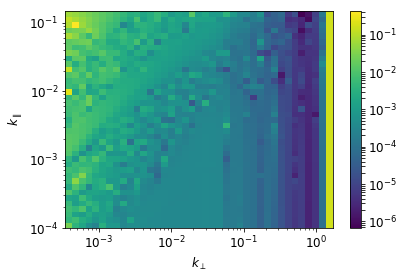

In [17]:
Z_var_sqrt=1./Z_inv_var_no_z
Z_var_sqrt=Z_var_sqrt.T
print (Z_var_sqrt)

pylab.pcolormesh(kperp_arr,kpar_arr,Z_var_sqrt,norm=LogNorm()) ;  cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
pylab.xlim([np.min(kperp_arr),np.max(kperp_arr)]) ; pylab.ylim([np.min(kpar_arr),np.max(kpar_arr)])
plt.xlabel(r'$k_\perp$',fontsize=12); plt.ylabel(r'$k_\parallel$',fontsize=12);
plt.xscale('log')
plt.yscale('log')
#plt.savefig('2D_bispec_fourier_z_1pt26_deltaz_pt005_and_below.png', dpi=300, bbox_inches='tight')
pylab.show()